In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 65.5 MB/s eta 0:00:00


Mounted at /content/drive


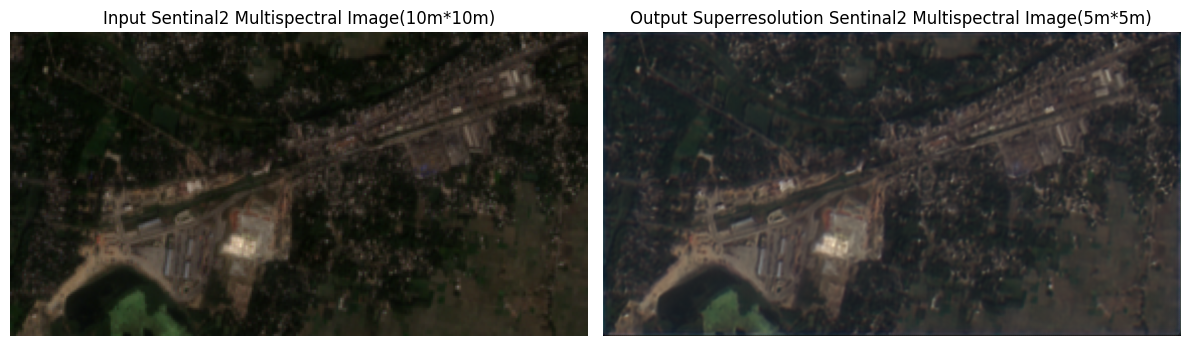

Input resolution: 151x287 pixels
Output resolution: 302x574 pixels
Image transform: | 10.00, 0.00, 691760.00|
| 0.00,-10.00, 2549680.00|
| 0.00, 0.00, 1.00|
Input pixel width in meters: 10.0
Input pixel height in meters: 10.0
Each input pixel represents an area of 100.00 m²
Each output pixel represents an area of 25.00 m²


In [ ]:
from google.colab import drive
import torch
import rasterio
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import sys
import os

# Mount Google Drive
drive.mount('/content/drive')

# Add the path to the directory containing models.py to the Python path
sys.path.append('/content/drive/My Drive/RCAN')  # Adjust the path to the directory containing models.py

# Now you can import your model architecture
from models import RCAN  # Ensure this matches the class name in your models.py file

# Load the PyTorch model
model_path = '/content/drive/My Drive/RCAN/REC_Real_L1B.pt'
model = RCAN(n_colors=4)  # Instantiate your model; adjust parameters as needed
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Read and preprocess the input image
tif_path = '/content/drive/My Drive/RCAN/JAN092023.tif'
with rasterio.open(tif_path) as src:
    image_data = src.read().astype('float32')
    image_data /= 10000.0  # Normalize the data if required by the model

# Add a batch dimension and convert to a tensor
input_tensor = torch.from_numpy(image_data).unsqueeze(0)

# Run the model to generate the output
with torch.no_grad():
    output = model(input_tensor)

# Convert the output to a numpy array and remove the batch dimension
output_data = output.squeeze(0).numpy()

# Post-process the output as needed (e.g., scaling to 8-bit)
# ...

# Function to convert bands to an RGB image for visualization
def bands_to_rgb(bands, title):
    # Normalize each band to [0, 1] for display purposes
    bands_norm = (bands - bands.min()) / (bands.max() - bands.min())
    # Stack the first three bands for RGB visualization
    rgb_image = np.dstack((bands_norm[2], bands_norm[1], bands_norm[0]))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis('off')

# Read and preprocess the input image
with rasterio.open(tif_path) as src:
    # Read the image data
    input_data = src.read().astype('float32')
    # Normalize the data if required by the model
    input_data /= 10000.0

# Convert the output to a numpy array and remove the batch dimension
output_data = output.squeeze(0).cpu().numpy()

# Visualize the input and output multispectral images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.sca(ax[0])
bands_to_rgb(input_data, 'Input Sentinal2 Multispectral Image(10m*10m)')

plt.sca(ax[1])
bands_to_rgb(output_data, 'Output Superresolution Sentinal2 Multispectral Image(5m*5m)')

# Show the plot with comparisons
plt.tight_layout()
plt.show()

# Print out the resolutions for comparison
print(f"Input resolution: {input_data.shape[1]}x{input_data.shape[2]} pixels")
print(f"Output resolution: {output_data.shape[1]}x{output_data.shape[2]} pixels")


# ... [previous code for loading the model and running inference] ...

# Read the metadata from the original image to get pixel size
with rasterio.open(tif_path) as src:
    # Print the transform to check its values
    print(f"Image transform: {src.transform}")

    # Extract pixel dimensions from the transform (affine matrix)
    pixel_width, pixel_height = src.transform[0], -src.transform[4]  # Negative sign to ensure positive values

# Assuming the model does not change the area covered by the pixel
input_pixel_area = pixel_width * pixel_height

# Set this to True if your model performs super-resolution, False otherwise
model_has_super_resolution = True  # Set this based on your model's behavior

# Calculate the output pixel area based on the model's behavior
output_pixel_area = input_pixel_area / 4 if model_has_super_resolution else input_pixel_area

# ... [visualization code] ...

# Print out the pixel sizes and resolutions for comparison
print(f"Input pixel width in meters: {pixel_width}")
print(f"Input pixel height in meters: {pixel_height}")
print(f"Each input pixel represents an area of {input_pixel_area:.2f} m²")
print(f"Each output pixel represents an area of {output_pixel_area:.2f} m²")



# # Save the output to Google Drive (optional)
# output_path = '/content/drive/My Drive/RCAN/super_JAN0923.tif'
# with rasterio.open(output_path, 'w', **src.meta) as dst:
#     dst.write(output_data)

# print(f"Output saved to {output_path}")


In [ ]:
#real saving

output_data *= 10000.0

# Convert output data to the appropriate type, e.g., uint16
output_data = output_data.clip(0, 10000).astype(np.uint16)

with rasterio.open(tif_path) as src:
    original_meta = src.meta

super_res_meta = original_meta.copy()
super_res_meta.update({
    'width': output_data.shape[2],
    'height': output_data.shape[1],
    'transform': rasterio.Affine(original_meta['transform'].a / 2, original_meta['transform'].b, original_meta['transform'].c,
                                 original_meta['transform'].d, original_meta['transform'].e / 2, original_meta['transform'].f),
    'dtype': 'uint16'
})

output_path = '/content/drive/My Drive/RCAN/super_JAN0923.tif'
with rasterio.open(output_path, 'w', **super_res_meta) as dst:
    dst.write(output_data)

In [ ]:
def spectral_ERGAS(img_origND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_orig = np.empty(img_origND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    mean_img_orig = np.empty(n_band)
    mean_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_orig[:,:,i] = img_origND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_orig[i] = img_orig[:,:,i].mean()
        mean_img_fus[i] = img_fus[:,:,i].mean()

        # Diference between the multispectral image and the fused image
        dif_imgs[:,:,i] = img_orig[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_orig[i] - mean_img_fus[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_orig[i]**2)

    # Spectral ergas
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

In [ ]:
from skimage.transform import resize
import math  # Add this line at the beginning of your

# Assuming output_data is the high-resolution image and input_data is the low-resolution image
# Resize the high-resolution image to match the low-resolution image's dimensions
output_data_resized = resize(output_data, input_data.shape, mode='reflect', anti_aliasing=True)

# Now calculate ERGAS using the resized high-resolution image
ERGAS_X = spectral_ERGAS(input_data, output_data_resized, 1/2, [1, 1, 1], 3)

# ... [Your existing code for resizing the high-resolution image] ...

# Calculate Spectral ERGAS value only
ERGAS_X = spectral_ERGAS(input_data, output_data_resized, 1/2, [1, 1, 1], 3)  # Adjust as needed

# Print or display Spectral ERGAS value
print("Spectral ERGAS:", ERGAS_X)

# ... [Your existing code for visualization and saving the output] ...



Spectral ERGAS: 23.10156975262237


In [ ]:
#for spatial , resampled pla.tif(panchromatic into 5m * 5m from 3.5m*3.5m)

In [ ]:
!pip install texttable
!pip install texttable rasterio

import ee
import geemap
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.exposure import match_histograms
import time
import texttable as tt
import rasterio
from rasterio.plot import reshape_as_raster

In [ ]:
out_dir = '/content/drive/My Drive/rec-2nd'

In [ ]:
filename_pan = os.path.join(out_dir, 'pla_resampled.tif')
# Panchromatic band
r_img_pan = rasterio.open(filename_pan)
img_pan = r_img_pan.read(1)
print('PlanetScope -> panchromatic shape:',img_pan.shape, '| Range (min, max): (', np.amin(img_pan), ',', np.amax(img_pan), ')')

PlanetScope -> panchromatic shape: (677, 1404) | Range (min, max): ( 0 , 2273 )


In [ ]:
# #EXTRA EXTRA EXTRA - for creating synthetic panchromatic band

# import os
# import numpy as np
# import rasterio

# # Assuming you have a directory path and the PlanetScope filename
# out_dir = '/content/drive/My Drive/rec-2nd'
# filename_planetscope = os.path.join(out_dir, 'pla_resampled.tif')  # Correct filename

# # Open the PlanetScope multispectral image
# with rasterio.open(filename_planetscope) as ps_img:
#     # Read only the RGB bands (assuming they are bands 1, 2, and 3)
#     blue = ps_img.read(1)
#     green = ps_img.read(2)
#     red = ps_img.read(3)

#     # Create a synthetic panchromatic band by averaging the RGB bands
#     img_pan = (blue.astype(float) + green.astype(float) + red.astype(float)) / 3
#     # pan_synthetic is now a single-band array representing the synthetic panchromatic band

# # Now you can proceed with the pansharpening process, using pan_synthetic as the high-resolution band

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Panchromatic image normalization
pan = (((img_pan - np.amin(img_pan)) / (np.amax(img_pan) - np.amin(img_pan))) * 255).astype(int)

# Create a single figure for the panchromatic image
plt.figure(figsize=(13, 10))

# Display the panchromatic image
plt.imshow(pan, cmap='gray')  # Ensure 'gray' color map for panchromatic image
plt.title("Panchromatic PlanetScope Image")
plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()


In [ ]:
# from skimage.transform import resize
# import math  # Add this line at the beginning of your

# # Assuming output_data is the high-resolution image and input_data is the low-resolution image
# # Resize the high-resolution image to match the low-resolution image's dimensions
# output_data_resized = resize(output_data, input_data.shape, mode='reflect', anti_aliasing=True)

# # Now calculate ERGAS using the resized high-resolution image
# ERGAS_X = spectral_ERGAS(input_data, output_data_resized, 1/2, [1, 1, 1], 3)

# # ... [Your existing code for resizing the high-resolution image] ...

# from skimage.transform import resize

# # Resize the panchromatic image to match the spatial dimensions of the super-resolved image
# # Assuming output_data_resized has shape [bands, height, width]
# pan_resized = resize(img_pan, output_data_resized.shape[1:], mode='reflect', anti_aliasing=True)

# # Now calculate the spatial ERGAS
# pan_resized_3d = np.expand_dims(pan_resized, axis=0)
# pan_resized_3d = np.repeat(pan_resized_3d, output_data_resized.shape[0], axis=0)



# ... [Your existing code for visualization and saving the output] ...

In [ ]:
# from google.colab import drive
# import rasterio
# from rasterio.enums import Resampling

# # Mount Google Drive
# drive.mount('/content/drive')

# # Path to the panchromatic image in Google Drive
# panchromatic_file_path = '/content/drive/My Drive/rec-2nd/pla.tif'

# # Read the panchromatic image
# with rasterio.open(panchromatic_file_path) as src:
#     # Calculate the scale for resampling (5m / 3.5m)
#     scale = 5.0 / 3.5

#     # Calculate the new dimensions
#     new_width = int(src.width * scale)
#     new_height = int(src.height * scale)

#     # Resample the image
#     pan_resampled = src.read(
#         1,
#         out_shape=(1, new_height, new_width),  # Corrected out_shape
#         resampling=Resampling.bilinear
#     )

#     # Update the transform for the new image size
#     new_transform = src.transform * src.transform.scale(
#         (src.width / new_width),
#         (src.height / new_height)
#     )

# # Save the resampled image back to Google Drive
# resampled_file_path = '/content/drive/My Drive/rec-2nd/pla_resampled.tif'
# with rasterio.open(
#     resampled_file_path, 'w',
#     driver='GTiff',
#     height=new_height,
#     width=new_width,
#     count=1,
#     dtype=pan_resampled.dtype,
#     crs=src.crs,
#     transform=new_transform,
# ) as dst:
#     dst.write(pan_resampled, 1)

# print("Resampled image saved to Google Drive")


In [ ]:
from skimage.transform import resize

# Print the shape of the super-resolved image for verification
print("Shape of super-resolved image (output_data_resized):", output_data_resized.shape)

# Resize the panchromatic image to match the spatial dimensions of the super-resolved image
pan_resized = resize(img_pan, (output_data_resized.shape[1], output_data_resized.shape[2]), mode='reflect', anti_aliasing=True)

# Convert the 2D panchromatic image to a 3D array by repeating it across the number of bands
pan_resized_3d = np.repeat(pan_resized[np.newaxis, :, :], output_data_resized.shape[0], axis=0)

# Now calculate the spatial ERGAS
#ERGAS_S = spatial_ERGAS(pan_resized_3d, output_data_resized, 1/2, [1,1,1], 3)

# Print or display the ERGAS values
print("Spectral ERGAS:", ERGAS_X)
#print("Spatial ERGAS:", ERGAS_S)


In [ ]:
def spatial_ERGAS(img_panND, img_fusND, ratio, coef_rad, n_band):
    # Initialize variables
    img_panc = np.empty((n_band, img_fusND.shape[1], img_fusND.shape[2]))
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    img_pan_hist = np.empty(img_fusND.shape)
    mean_img_pan = np.empty(n_band)
    mean_img_multi = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)

    for i in range(n_band):
        img_panc[i,:,:] = img_panND[i,:,:] * coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i] * coef_rad[i]

        # Mean value of the radiances per band
        mean_img_pan[i] = img_panc[i,:,:].mean()
        mean_img_multi[i] = img_fus[:,:,i].mean()

        if mean_img_pan[i] < 1e-10:
            print(f"Band {i} has a very small mean value in the panchromatic image: {mean_img_pan[i]}")
            razon_img_fus[i] = 0  # Set to zero or handle as appropriate
        else:
            razon_img_fus[i] = rmse_img_fus[i] / (mean_img_pan[i]**2)

        # Histogram of the panchromatic image
        delta_media = mean_img_multi[i] - mean_img_pan[i]
        img_pan_hist[i,:,:] = img_panc[i,:,:] + delta_media

        # Difference between the panchromatic image and the fused image
        dif_imgs[:,:,i] = img_pan_hist[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_pan[i] - mean_img_multi[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i] / (mean_img_pan[i]**2)

        print(f"Band {i}: mean_img_pan = {mean_img_pan[i]}, mean_img_multi = {mean_img_multi[i]}")
        print(f"Band {i}: rmse_img_fus = {rmse_img_fus[i]}, std_imgs = {std_imgs[i]}")

    ergas_value = 100 * (ratio**2) * math.sqrt(razon_img_fus.mean())
    print("Final Spatial ERGAS Value:", ergas_value)


    # Spatial ERGAS
    return ergas_value

In [ ]:
# Confirm the shape of pan_resized_3d
print("Shape of pan_resized_3d:", pan_resized_3d.shape)

# If pan_resized_3d is correctly shaped, proceed with the calculation
ERGAS_S = spatial_ERGAS(pan_resized_3d, output_data_resized, 1/2, [1,1,1], 3)
print("Spatial ERGAS:", ERGAS_S)


In [ ]:
#for histogram comparsion between original and super resolved

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Paths to the images
super_res_path = '/content/drive/My Drive/RCAN/super_JAN0923.tif'
sentinel_path = '/content/drive/My Drive/RCAN/JAN092023.tif'

# Load the super-resolution image
with rasterio.open(super_res_path) as super_res_img:
    super_res_data = super_res_img.read(1)  # Read the first band

# Load the original Sentinel-2 image
with rasterio.open(sentinel_path) as sentinel_img:
    sentinel_data = sentinel_img.read(1)  # Read the first band

# Plot histograms for pixel comparison
plt.figure(figsize=(12, 6))

# Histogram for the original Sentinel-2 image
plt.subplot(1, 2, 1)
plt.hist(sentinel_data.ravel(), bins=256, color='blue', alpha=0.7)
plt.title('Histogram of Original Sentinel-2 Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Histogram for the Super Resolution image
plt.subplot(1, 2, 2)
plt.hist(super_res_data.ravel(), bins=256, color='green', alpha=0.7)
plt.title('Histogram of Super Resolution Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
